In [18]:
# magics: ensures that any changes to the modules loaded below will be re-loaded automatically

# load general packages
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

# load modules related to this exercise
import tools 
from model_dc_multidim import model_dc_multidim
import egm_dc_multidim as egm
import time
import random

In [6]:
egm.pens_fun(1001, 0)

8.19590192686237

In [7]:
def marg_pens(m, wage):
    v = 0.1
    return -(0.00499 * np.exp((0.00499 * m + 10.75973 - 0.00499 * 117.08260)/v) ) / ( ( np.exp(0.00499 * (m - 117.08260)/v ) + np.exp(0.27749 * wage/v) + np.exp(10.75973/v) +1)  * (np.exp(0.00499 *(m - 117.08260)/v ) + np.exp(wage * 0.27749/v) +1 ) )

marg_pens(1000, 0)

-0.004989999999999929

In [8]:
model = model_dc_multidim()
model.setup()
model.create_grids()

In [9]:
t0 = time.time()  # set the starting time
model = model_dc_multidim()
model.setup()
model.create_grids()
model.solve()
t1 = time.time() # set the ending time
print(f'time: {t1-t0:.8} seconds') # print the total time

Evalutating: cg, low
Evalutating period: 88
Evalutating period: 87
Evalutating period: 86
Evalutating period: 85


KeyboardInterrupt: 

In [10]:

egm.human_capital(1, 60, model.par)

53.49402684971406

array(['high', 'high', 'high', 'high', 'high', 'high', 'high', 'high',
       'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high',
       'high', 'high', 'low', 'high', 'high', 'low', 'high', 'high',
       'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high',
       'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high',
       'high', 'low', 'high', 'high', 'high', 'high', 'high', 'high',
       'high', 'high', 'high', 'high', 'high', 'high', 'high', 'low',
       'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high',
       'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high',
       'high', 'high', 'low', 'high', 'high', 'high', 'high', 'high',
       'low', 'high', 'high', 'high', 'high', 'low', 'high', 'high',
       'low', 'high', 'high', 'high', 'low', 'high', 'low', 'high',
       'high', 'high', 'high', 'low'], dtype='<U4')

In [122]:
def pens_fun(m, wage):
    year = 2015
    m_asset_test = m
    pens = soft_max(10.75973 + 1.84692 * (year > 2010) 
                    - soft_max(0, soft_max(0.27749 * wage, 0.00499 * (m_asset_test - 117.08260))), 0)
    return pens

def tax_fun(income, par):
    thld_1 = 17.3918
    thld_2 = 73.1766

    if income < thld_1:
        return 0 * income
    if income < thld_2:
        return 0.29907 * (income - thld_1)
    return 0.37930 * (income - thld_2) + 0.29907 * thld_2

def human_capital(e, t, par, tau=("cg","high")):
    print(tau)
    edu, skill = tau
    t -= 20
    return np.exp(par.eta_0[edu] + par.eta_0[skill] + par.eta_1[edu] * t*e + par.eta_2[edu] * (t*e)**2 + par.eta_3*t + par.eta_4*t**2)

def soft_max(x, y):
    v = 0.3
    return v * np.log(np.exp(x/v) + np.exp(y/v))

def pens_fun(m, wage):
    year = 2015
    m_asset_test = m
    pens = soft_max(10.75973 + 1.84692 * (year > 2010) 
                    - soft_max(0, soft_max(0.27749 * wage, 0.00499 * (m_asset_test - 117.08260))), 0)
    return pens

def res(V, sigma):
    # Maximum over the discrete choices (0 = for each column, i.e., for each "competing choice")
    mxm = V.max(0)
    # numerically robust log-sum
    log_sum = mxm + sigma*(np.log(np.sum(np.exp((V - mxm) / sigma),axis=0)))
    prob = np.exp((V- log_sum) / sigma)    
    return prob    

def simulate (model):
    par = model.par
    sol = model.sol
    sim = model.sim
    
    par.simT = par.T
    
    # Initialize
    shape = (par.simT, par.simN)
    sim.m = np.nan +np.zeros(shape)
    sim.c = np.nan +np.zeros(shape)
    sim.a = np.nan +np.zeros(shape)
    sim.e = np.nan +np.zeros(shape)
    sim.income = np.nan +np.zeros(shape)
    sim.pens = np.nan +np.zeros(shape)
    
    sim.h = np.nan +np.zeros(shape)
    sim.v = np.nan +np.zeros(shape)
    sim.y = np.nan +np.zeros(shape)
    sim.wage = np.nan +np.zeros(shape)
    
    pp = par.high_proportion["cg"]
    np.random.choice(np.array(["high", "low"]), (par.simN) , p = [pp, 1- pp])
    
    sim.m[par.Tmin,:] = np.random.lognormal(0, 1.48960, par.simN) + par.tr

    # Simulation 
    model.par.H_bunches = np.array(model.par.H_bunches)
    
    
    # HOW TO GET TYPES -> LOOP OVER THEM CHANGE tau, split simN into two, one for high and low
    tau=("cg","high")
    edu, skill = tau 
    for t in range(par.Tmin, par.simT):
        V = np.zeros( (6, model.par.simN) )
        C = np.zeros( (6, model.par.simN) )
        for i, h_i in enumerate(model.par.H_bunches): # possible hour choices
            if t == par.Tmin:
                sim.e[t,:] = par.H_bunches[2] / par.H_bunches[5]
            
            C[i, :] =tools.interp_2d_vec(par.grid_m, par.grid_e, sol.c[t, i], sim.m[t, :], sim.e[t, :])
            V[i, :] = tools.interp_2d_vec(par.grid_m , par.grid_e, sol.v[t, i ], sim.m[t, :], sim.e[t, :]) 
        

        prob_work = res(V, model.par.lambda_scale)
        
        def test(x):
            #x = np.asarray(x).astype('float64')
            #prop = x / ( np.sum(x) )
            #print(x)
            return np.random.choice(np.array([0, 1, 2, 3, 4, 5]),  p = x )
        
        h_i = np.apply_along_axis(test, 0, prob_work)
        if t > 84:
            h_i = h_i * 0
        #print(prob_work[:,0].argmax(0))
        #h_i = prob_work.argmax(0)
        #print(np.sum(prob_work[:, 0]))
        
        #w_raw = w*np.reshape(V_plus,(par.Na,par.Nxi))
        
        #h_i = V.argmax(0) # index of best choice

        Vs = V[:, h_i][0, :]
        Cs = C[:, h_i][0, :] # magic to get all the best choices
        sim.c[t, :] = Cs
        sim.v[t, :] = Vs
        sim.a[t,:] = sim.m[t,:] - sim.c[t,:]
        
        h_plus = model.par.H_bunches[h_i]
        sim.h[t] = h_plus
        #print(h_plus)
        #print(sim.e[t, :])
        if t< par.simT-1:
            
            xi, xi_w = tools.GaussHermite_lognorm(par.sigma_1 + par.sigma_2 * t, par.simN)
            #print(xi.shape)
            sim.xi = np.random.choice(xi, (par.simN),replace=True,p=xi_w)
            
            tax_fun_ = np.vectorize(tax_fun)
            
            e_plus = (1/(1 + t)) * (t * sim.e[t,:] + h_plus/par.H_bunches[5])
            #print(e_plus)
            #print(e_plus)
            K_plus = human_capital(e_plus, t, par)
            sim.e[t+1] = e_plus

            wage_plus = K_plus * sim.xi # K
            sim.wage[t, :] = wage_plus
            income = h_plus * wage_plus / 1000
            sim.income[t, : ] = income
            
            a = sim.m[t, :] - sim.c[t, :]
            super_payment = K_plus * par.rho[edu] * (t == 65)   
            m_plus = par.interest * a + income - tax_fun_(income, par)  + par.tr * (t+1 <= 3) # wealth before pens
            
            pens = pens_fun(m_plus, income) * (t > 65)
            m_plus += super_payment
            m_plus += pens
            
            sim.pens[t, :] = pens
            #print(np.average(sim.c))
           
            sim.m[t+1, :] = m_plus
            
simulate(model)

TypeError: No matching definition for argument type(s) array(float64, 1d, C), array(float64, 1d, C), array(float64, 4d, C), array(float64, 1d, C), array(float64, 1d, C)

In [105]:
#plt.plot(np.random.lognormal(0, 1.48960, model.par.simN))

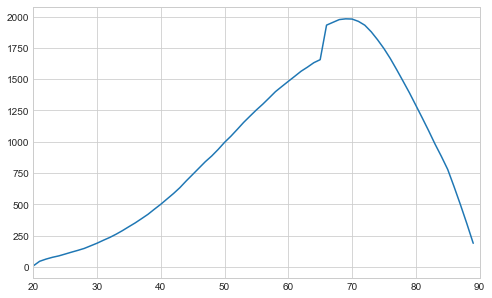

In [115]:
hs = []
for i in range(model.par.Tmin, model.par.T):
    h = model.sim.m[i, :]
    #print(h)
    #hh = egm.util( model.sim.m[i, :] , model.sim.h[i, :][0], i, model.par)
    #h = model.sim.h[i, :]
    #print(i)
    h = np.average(h)
    hs.append(h)
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(model.par.Tmin, model.par.T)
ax.plot(list(range(model.par.Tmin, model.par.T)) , hs)

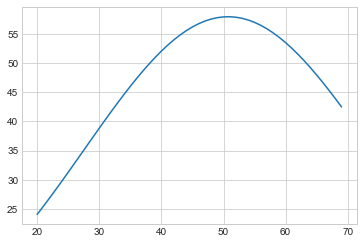

In [10]:
vs = []
ds = []
years = list(range(20, 70))
for i in years:
    ds.append( egm.human_capital(1, i, model.par) )
    vs.append( egm.util_bequest(10*i, model.par, False) )
plt.plot(years, ds)
#plt.plot(vs)

[25, 40, 50, 60, 70, 80]
275.137821472432
251.85265464707743
218.73788238460912
176.94448107957433
116.05042554837111
68.76648777256229


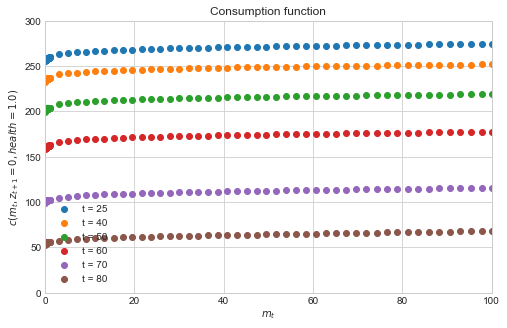

[25, 40, 50, 60, 70, 80]
277.7165155880578
256.0908241779397
223.26303911112072
180.72571357414301
117.73685562031683
68.36077810235007


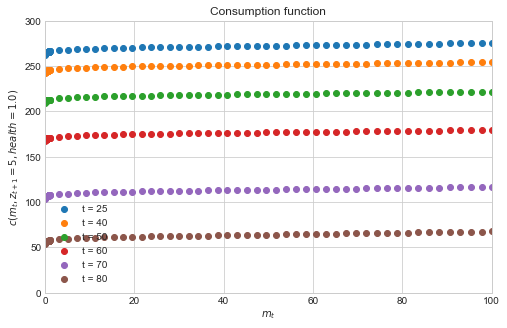

In [11]:
# Figure
def figure_multi_dim(par,sol,T,i_h):
    p = par.grid_e[i_h]

    ts = [25, 40, 50, 60, 70, 80]
    print(ts)
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(1,1,1)
    
    for i in ts:
        print(np.average(sol.v[i-1,T,:,i_h]))
        ax.scatter(par.grid_m,sol.v[i-1,T,:,i_h], label=f't = {i}')
    ax.set_xlabel(f"$m_t$")
    ax.set_ylabel(f"$c(m_t,z_{{t+1}} = {T}, health = {p:.3})$")
    ax.set_xlim([0, 100])
    ax.set_ylim([0,300])
    ax.set_title(f'Consumption function')
    plt.legend()
    plt.show()

figure_multi_dim(model.par,model.sol, 0, 99)
figure_multi_dim(model.par,model.sol, 5, 99)
#figure_multi_dim(model.par,model.sol, 10, 50)
#figure_multi_dim(model.par,model.sol, 30, 50)

In [12]:
egm.util(10, 0, 10, model.par)


7.818293900984182

In [13]:
c = 10
par.zeta = model.par.zeta
print(par.zeta)
((c**(1.0-par.zeta))/(1.0-par.zeta))

NameError: name 'par' is not defined

In [ ]:
def soft_max(x, y):
    v = 0.1
    return v * np.log(np.exp(x/v) + np.exp(y/v))
soft_max(40,2)